In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# @title Imports
!pip install tensorflow

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.check_data import prepare_time_series
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.dataset_builder import DatasetBuilderForYourColumns
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.ppo_training import train, prepare_datasets
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.indicators import *

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [2]:
# @title Load and check data

# PATH_TO_DATA = "dummy_df.joblib"  # <-- provide path
PATH_TO_DATA = "/content/drive/MyDrive/stocks/Data/DOGEUSDT/raw_data/DOGEUSDT_1m_2024-01-01_to_2025-05-23.joblib"
START = "2024-01-20"
END = "2025-05-23"
TIMESTAMP_COL = "timestamp"          # column with timestamps

raw_df = joblib.load(PATH_TO_DATA).loc[START:END]
df = prepare_time_series(raw_df, timestamp_col=TIMESTAMP_COL)
print(f"From {df.index[0]} to {df.index[-1]}")

From 2024-01-20 00:00:00+00:00 to 2025-05-23 23:59:00+00:00


In [3]:
# @title Add indicators

# Базовые массивы (создаём один раз)
close  = df['Close'].to_numpy(np.float64)
high   = df['High'].to_numpy(np.float64)
low    = df['Low'].to_numpy(np.float64)
volume = df['Volume'].to_numpy(np.float64)

# Словарь для новых колонок
new_cols = {}
obv_arr = obv_numba(close, volume)

for i in range(35, 246, 7):
    ema_i = ema_numba(close, i)
    sma_i = sma_numba(close, i)
    adx_i = adx_numba(high, low, close, i)
    atr_i = atr_numba(high, low, close, i)
    rsi_i = rsi_numba(close, i)

    fast = i
    slow = i * 2
    sig  = i // 2  # вместо int(i/2)

    macd, macd_signal, macd_hist = macd_numba(close, fast, slow, sig)
    stoch_k, stoch_d = stoch_numba(high, low, close, i, i // 2)
    boll_mid, boll_up, boll_dn = bollinger_numba(close, i, 2.0)
    cci_i  = cci_numba(high, low, close, i)
    willr_i= williams_r_numba(high, low, close, i)
    mfi_i  = mfi_numba(high, low, close, volume, i)
    roc_i  = roc_numba(close, i)
    vwap_i = vwap_numba(high, low, close, volume, i)  # если это rolling VWAP на окне i

    new_cols.update({
        f"EMA_{i}":          ema_i,
        f"SMA_{i}":          sma_i,
        f"ADX_{i}":          adx_i,
        f"ATR_{i}":          atr_i,
        f"RSI_{i}":          rsi_i,
        f"MACD_{i}":         macd,
        f"MACD_signal_{i}":  macd_signal,
        f"MACD_hist_{i}":    macd_hist,
        f"STOCH_K_{i}":      stoch_k,
        f"STOCH_D_{i}":      stoch_d,
        f"BOLL_MID_{i}":     boll_mid,
        f"BOLL_UP_{i}":      boll_up,
        f"BOLL_DN_{i}":      boll_dn,
        f"OBV":              obv_arr,
        f"CCI_{i}":          cci_i,
        f"WILLR_{i}":        willr_i,
        f"MFI_{i}":          mfi_i,
        f"ROC_{i}":          roc_i,
        f"VWAP_{i}":         vwap_i,
    })

# Добавляем все столбцы разом — без фрагментации
df = pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)

print(df.columns.to_list())

['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'EMA_35', 'SMA_35', 'ADX_35', 'ATR_35', 'RSI_35', 'MACD_35', 'MACD_signal_35', 'MACD_hist_35', 'STOCH_K_35', 'STOCH_D_35', 'BOLL_MID_35', 'BOLL_UP_35', 'BOLL_DN_35', 'OBV', 'CCI_35', 'WILLR_35', 'MFI_35', 'ROC_35', 'VWAP_35', 'EMA_42', 'SMA_42', 'ADX_42', 'ATR_42', 'RSI_42', 'MACD_42', 'MACD_signal_42', 'MACD_hist_42', 'STOCH_K_42', 'STOCH_D_42', 'BOLL_MID_42', 'BOLL_UP_42', 'BOLL_DN_42', 'CCI_42', 'WILLR_42', 'MFI_42', 'ROC_42', 'VWAP_42', 'EMA_49', 'SMA_49', 'ADX_49', 'ATR_49', 'RSI_49', 'MACD_49', 'MACD_signal_49', 'MACD_hist_49', 'STOCH_K_49', 'STOCH_D_49', 'BOLL_MID_49', 'BOLL_UP_49', 'BOLL_DN_49', 'CCI_49', 'WILLR_49', 'MFI_49', 'ROC_49', 'VWAP_49', 'EMA_56', 'SMA_56', 'ADX_56', 'ATR_56', 'RSI_56', 'MACD_56', 'MACD_signal_56', 'MACD_hist_56', 'STOCH_K_56', 'STOCH_D_56', 'BOLL_MID_56', 'BOLL_UP_56', 'BOLL_DN_56', 'CCI_56', 'WILLR_56', 'MFI_56', 'ROC_56', 'VWAP_56', 'EMA_63', 'SMA_63', 'ADX_63', 'ATR_63', 'RSI_63', 'MACD_63', 

In [4]:
# @title Параметры

SPLITS = (0.8, 0.10, 0.10)
SEQ_LEN = 5
BEST_PATH = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/exp1/best_lstm.weights.h5"
BEST_BACKBONE_PATH = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/exp1/best_backbone.weights.h5"


FEE = 0.0002
SLIPPAGE = 0.0001
T = None

FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume']
for i in [189, 210, 217]:
  inds = [f'EMA_{i}', f'SMA_{i}', f'ADX_{i}', f'ATR_{i}', f'RSI_{i}', f'MACD_{i}', f'MACD_signal_{i}', f'MACD_hist_{i}',
      f'STOCH_K_{i}', f'STOCH_D_{i}', f'BOLL_MID_{i}', f'BOLL_UP_{i}', f'BOLL_DN_{i}',
      f'CCI_{i}', f'WILLR_{i}', f'MFI_{i}', f'ROC_{i}', f'VWAP_{i}']
  FEATURES = FEATURES + inds

ACCOUNT_F = [
    "Unreal_PnL", "Flat_Steps", "Hold_Steps", "Drawdown", "Pos",
]

# @title PPO training parameters


PPO_SEQ_LEN = SEQ_LEN
PPO_FEATURES_DIM = len(FEATURES) + len(ACCOUNT_F)
PPO_SAVE_PATH = '/content/drive/MyDrive/stocks/pretrained_rl_ppo/ppo_weights/exp1'
PPO_NUM_ACTIONS = 4
PPO_UNITS_PER_LAYER = [64]
PPO_DROPOUT = 0.5
# PPO params
PPO_UPDATES = 10
PPO_N_ENV = 40
PPO_ROLLOUT = 512
PPO_ACTOR_LR = 3e-4
PPO_CRITIC_LR = 1e-3
PPO_CLIP_RATIO = 0.2
PPO_C1 = 0.5
PPO_C2 = 0.01
PPO_EPOCHS = 10
PPO_BATCH_SIZE = 64
PPO_TEACHER_KL = 0.1
PPO_KL_DECAY = 0.98
PPO_TARGET_KL = 0.01
PPO_MAX_GRAD_NORM = 0.5
PPO_VAL_INTERVAL = 1
PPO_DEBUG = True


In [5]:
    # Подготавливаем данные и вычисляем статистики нормализации
ppo_train_df, ppo_val_df, ppo_test_df, _feat_stats = prepare_datasets(df,
                                                                      FEATURES,
                                                                      splits=SPLITS,
                                                                      norm_kind='minmax')

train: debug mode enabled
CPU available: 44
Teacher policy
evaluate_profit metrics={'Realized PnL': 0.0299, 'Annual Return': 0.0036, 'Sharpe Ratio': 0.2006, 'Sortino Ratio': 0.1985, 'Closed trades': 16, 'Avg PnL per trade': 0.0021, 'Maximum Drawdown': 2.018, 'Calmar Ratio': 0.0018, 'Profit Factor': 2.6604, 'Win Rate': 62.5, 'Average Win/Loss Ratio': 1.5963, 'Recovery Factor': 0.0148, 'Time Under Water': 0.8397, 'Value at Risk': 0.0017}


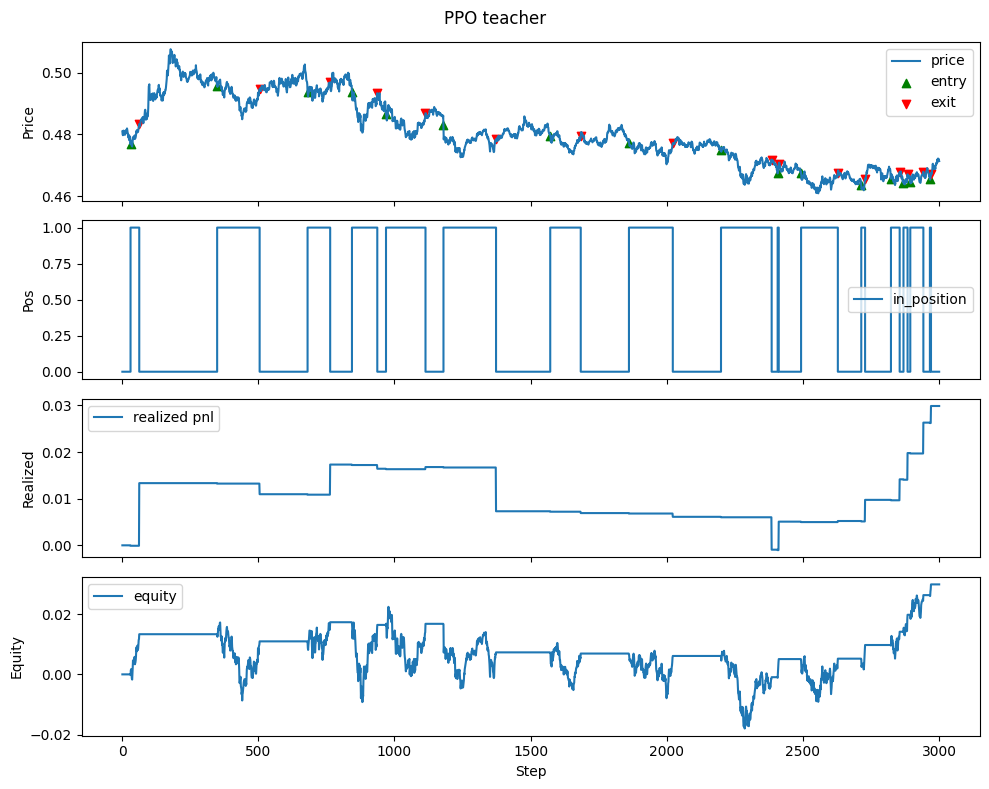

collect_trajectories: n_env=40 rollout=512 seq_len=5
ppo_update: epoch 1/10
batch: policy_loss=0.00164 value_loss=1.38971 entropy=0.44695 approx_kl=0.02611
ppo_update: epoch 2/10
batch: policy_loss=0.03193 value_loss=0.94573 entropy=0.44952 approx_kl=0.01053
ppo_update: epoch 3/10
batch: policy_loss=-0.00912 value_loss=1.21816 entropy=0.44122 approx_kl=0.00416
batch: policy_loss=0.09607 value_loss=0.73711 entropy=0.44269 approx_kl=-0.03560
batch: policy_loss=-0.01270 value_loss=1.14611 entropy=0.43946 approx_kl=0.00808
batch: policy_loss=-0.00239 value_loss=1.13575 entropy=0.40482 approx_kl=-0.04808
batch: policy_loss=0.01752 value_loss=0.89859 entropy=0.41587 approx_kl=0.00195
batch: policy_loss=0.00087 value_loss=0.69084 entropy=0.34416 approx_kl=0.01523
ppo_update: epoch 4/10
batch: policy_loss=0.00142 value_loss=0.78029 entropy=0.36574 approx_kl=0.03863
ppo_update: epoch 5/10
batch: policy_loss=0.08156 value_loss=0.74929 entropy=0.46375 approx_kl=-0.02578
batch: policy_loss=0.00133

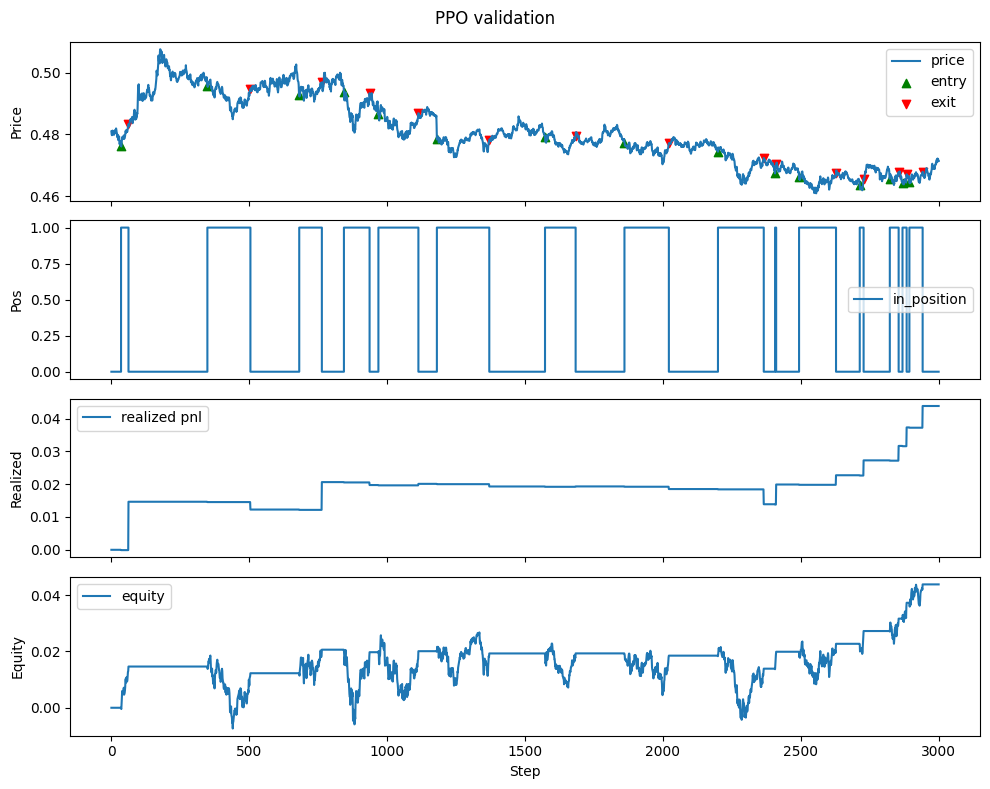

update=0 avg_reward=-0.553 profit=0.044 kl_coef=0.0980
collect_trajectories: n_env=40 rollout=512 seq_len=5
ppo_update: epoch 1/10
batch: policy_loss=0.01344 value_loss=0.69939 entropy=0.41142 approx_kl=0.03922
ppo_update: epoch 2/10
batch: policy_loss=0.01375 value_loss=0.96051 entropy=0.38389 approx_kl=0.03685
ppo_update: epoch 3/10
batch: policy_loss=0.01362 value_loss=0.80166 entropy=0.42023 approx_kl=0.01499
ppo_update: epoch 4/10
batch: policy_loss=-0.01089 value_loss=0.67377 entropy=0.40414 approx_kl=0.02508
ppo_update: epoch 5/10
batch: policy_loss=-0.00137 value_loss=0.53180 entropy=0.40781 approx_kl=0.01504
ppo_update: epoch 6/10
batch: policy_loss=0.01393 value_loss=0.46636 entropy=0.40864 approx_kl=0.01698
ppo_update: epoch 7/10
batch: policy_loss=-0.00042 value_loss=0.48935 entropy=0.36668 approx_kl=-0.00403
batch: policy_loss=0.00590 value_loss=0.39724 entropy=0.35106 approx_kl=0.04431
ppo_update: epoch 8/10
batch: policy_loss=0.00805 value_loss=0.44684 entropy=0.39615 ap

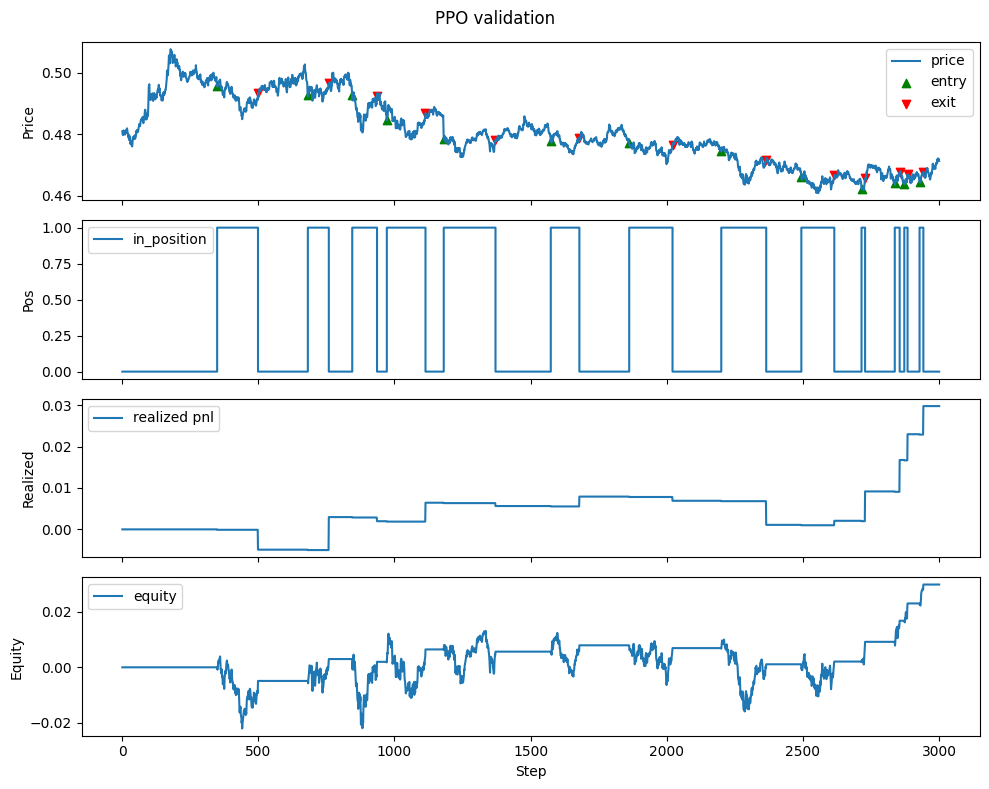

update=1 avg_reward=0.029 profit=0.030 kl_coef=0.0960
collect_trajectories: n_env=40 rollout=512 seq_len=5
ppo_update: epoch 1/10
batch: policy_loss=0.00380 value_loss=0.74337 entropy=0.39172 approx_kl=-0.00288
batch: policy_loss=0.00055 value_loss=0.52336 entropy=0.40786 approx_kl=0.02872
ppo_update: epoch 2/10
batch: policy_loss=0.00295 value_loss=0.53463 entropy=0.41838 approx_kl=-0.00126
batch: policy_loss=0.02648 value_loss=0.56023 entropy=0.39856 approx_kl=0.01828
ppo_update: epoch 3/10
batch: policy_loss=0.01075 value_loss=0.31599 entropy=0.40596 approx_kl=0.03320
ppo_update: epoch 4/10
batch: policy_loss=0.02930 value_loss=0.42462 entropy=0.43468 approx_kl=0.01189
ppo_update: epoch 5/10
batch: policy_loss=0.00542 value_loss=0.27683 entropy=0.42544 approx_kl=0.01094
ppo_update: epoch 6/10
batch: policy_loss=0.04017 value_loss=0.27976 entropy=0.40305 approx_kl=-0.00434
batch: policy_loss=0.02864 value_loss=0.34639 entropy=0.41299 approx_kl=-0.00611
batch: policy_loss=0.01533 valu

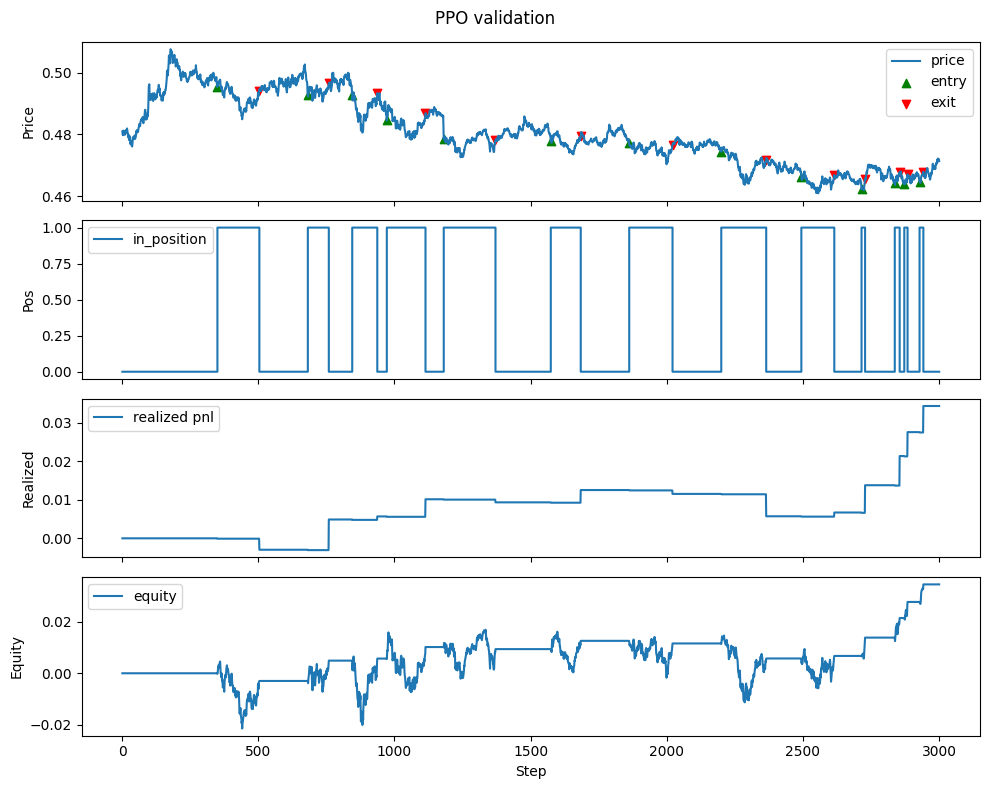

update=2 avg_reward=0.617 profit=0.034 kl_coef=0.0941
collect_trajectories: n_env=40 rollout=512 seq_len=5


In [ ]:
TRAIN_CFG = EnvConfig(
    mode=1,
    fee=FEE,
    spread=SLIPPAGE,
    leverage=1.0,
    max_steps=PPO_ROLLOUT+PPO_SEQ_LEN,
    reward_scale=1.0,
    use_log_reward=False,
    time_penalty=0.0,
    hold_penalty=0.0,
)

VAL_CFG = EnvConfig(
    mode=1,
    fee=FEE,
    spread=SLIPPAGE,
    leverage=1.0,
    max_steps=3000,
    reward_scale=1.0,
    use_log_reward=False,
    time_penalty=0.0,
    hold_penalty=0.0,
)

TEST_CFG = EnvConfig(
    mode=1,
    fee=FEE,
    spread=SLIPPAGE,
    leverage=1.0,
    max_steps=1e9,
    reward_scale=1.0,
    use_log_reward=False,
    time_penalty=0.0,
    hold_penalty=0.0,
)


actor, critic, train_log, val_log = train(
    ppo_train_df,
    ppo_val_df,
    ppo_test_df,
    TRAIN_CFG,
    VAL_CFG,
    TEST_CFG,
    PPO_FEATURES_DIM,
    FEATURES,
    seq_len = PPO_SEQ_LEN,
    teacher_weights = BEST_PATH,
    backbone_weights = BEST_BACKBONE_PATH,
    save_path = PPO_SAVE_PATH,
    num_actions = PPO_NUM_ACTIONS,
    units_per_layer = PPO_UNITS_PER_LAYER,
    dropout = PPO_DROPOUT,
    updates = PPO_UPDATES,
    n_env = PPO_N_ENV,
    rollout = PPO_ROLLOUT,
    actor_lr = PPO_ACTOR_LR,
    critic_lr = PPO_CRITIC_LR,
    clip_ratio = PPO_CLIP_RATIO,
    c1 = PPO_C1,
    c2 = PPO_C2,
    epochs = PPO_EPOCHS,
    batch_size = PPO_BATCH_SIZE,
    teacher_kl = PPO_TEACHER_KL,
    kl_decay = PPO_KL_DECAY,
    max_grad_norm = PPO_MAX_GRAD_NORM,
    target_kl = PPO_TARGET_KL,
    val_interval = PPO_VAL_INTERVAL,
    debug = PPO_DEBUG
)

In [ ]:
# @title Test simulation

